# scGPT zero shot evaluation

In [1]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import dask.dataframe as dd

from scipy.sparse import csr_matrix
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Convert to h5ad files

In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'

In [3]:
def get_count_matrix(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    
    return x


In [4]:
n_cells_train = 1_500_000

ddf_train = dd.read_parquet(join(DATA_PATH, 'train'), split_row_groups=True)
x_train = get_count_matrix(ddf_train)[:n_cells_train, :]
y_train = dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type']).compute().iloc[:n_cells_train]

ddf_test = dd.read_parquet(join(DATA_PATH, 'test'), split_row_groups=True)
x_test = get_count_matrix(ddf_test)
y_test = dd.read_parquet(join(DATA_PATH, 'test'), columns=['cell_type']).compute()

var = pd.read_parquet(join(DATA_PATH, 'var.parquet'))

#### Training data

In [ ]:
# run inference in batches to save memory

for i, idxs in tqdm(enumerate(np.array_split(np.arange(x_train.shape[0]), 10))):
    # data is already normalized
    anndata.AnnData(
        X=x_train[idxs, :].map_blocks(csr_matrix).compute(), 
        var=var.set_index('feature_name'),
        obs=y_train.iloc[idxs]
    ).write_h5ad(join(SAVE_PATH, 'train', f'{i}.h5ad'))


#### Test data

In [ ]:
for i, idxs in tqdm(enumerate(np.array_split(np.arange(x_test.shape[0]), 30))):
    # data is already normalized
    anndata.AnnData(
        X=x_test[idxs, :].map_blocks(csr_matrix).compute(), 
        var=var.set_index('feature_name'),
        obs=y_test.iloc[idxs]
    ).write_h5ad(join(SAVE_PATH, 'test', f'{i}.h5ad'))


## Get embeddings from scGPT

In [6]:
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'

In [7]:
from pathlib import Path
from os.path import join

import scgpt as scg
import anndata
import scanpy as sc

In [9]:
model_dir = Path("/mnt/dssfs02/scTab-checkpoints/scGPT")
cell_type_key = "cell_type"
gene_col = "index"

#### Training data

In [ ]:
for i in range(10):
    adata = sc.read_h5ad(join(SAVE_PATH, 'train', f'{i}.h5ad'))
    adata = scg.tasks.embed_data(
        adata,
        model_dir,
        cell_type_key=cell_type_key,
        gene_col=gene_col,
        batch_size=64,
        return_new_adata=True,
    ).write_h5ad(join(SAVE_PATH, 'train', f'{i}_embed.h5ad'))


#### Test data

In [ ]:
for i in range(30):
    adata = sc.read_h5ad(join(SAVE_PATH, 'test', f'{i}.h5ad'))
    adata = scg.tasks.embed_data(
        adata,
        model_dir,
        cell_type_key=cell_type_key,
        gene_col=gene_col,
        batch_size=64,
        return_new_adata=True,
    ).write_h5ad(join(SAVE_PATH, 'test', f'{i}_embed.h5ad'))


## Evaluate scGPT embeddings

### Train Linear model

In [ ]:
!pip install scanpy

In [31]:
from os.path import join

import anndata
import scanpy as sc
import numpy as np

from cuml.linear_model import LogisticRegression

In [32]:
SAVE_PATH = '/mnt/dssfs02/scGPT-splits'
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [ ]:
X = []
y = []


for i in range(10):
    adata = sc.read_h5ad(join(SAVE_PATH, 'train', f'{i}_embed.h5ad'))
    X.append(adata.X)
    y.append(adata.obs.cell_type.to_numpy())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [34]:
clf_list = []

for i in range(5):
    clf_list.append(LogisticRegression(class_weight='balanced', max_iter=5000, C=1000).fit(X, y))


### Evaluate on test data

In [35]:
import pandas as pd
from sklearn.metrics import classification_report
from statistics import mean, stdev

from utils import correct_labels

In [36]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [ ]:
X_test = []
y_test = []


for i in range(30):
    adata = sc.read_h5ad(join(SAVE_PATH, 'test', f'{i}_embed.h5ad'))
    X_test.append(adata.X)
    y_test.append(adata.obs.cell_type.to_numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [38]:
clf_reports = []

for clf in clf_list:
    preds = clf.predict(X_test)
    preds_corr = correct_labels(y_test, preds, cell_type_hierarchy)
    clf_reports.append(pd.DataFrame(classification_report(y_test, preds_corr, output_dict=True)).T)


In [39]:
f1_scores_scgpt = [clf_report.loc['macro avg', 'f1-score'] for clf_report in clf_reports]
print(f'{mean(f1_scores_scgpt):.4f}±{stdev(f1_scores_scgpt):.4f}')

0.7301±0.0035


## Evaluate on PCA embeddings

In [1]:
from os.path import join

import numpy as np
import dask.dataframe as dd

from cuml.linear_model import LogisticRegression

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

### Train linear model 

In [4]:
n_cells_train = 1_500_000  # take same amount of cells as for scGPT + celltypist

x_pca = np.load(join(DATA_PATH, 'pca/x_pca_training_train_split_256.npy'))[:n_cells_train, :]  

In [5]:
y_pca = dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type']).compute().iloc[:n_cells_train]

In [11]:
y_pca = y_pca.to_numpy().flatten()

In [24]:
clf_list_pca = []

for i in range(5):
    clf_list_pca.append(LogisticRegression(class_weight='balanced', max_iter=15000, C=1000).fit(x_pca, y_pca))


### Evaluate on test data

In [25]:
import pandas as pd
from sklearn.metrics import classification_report
from statistics import mean, stdev

from utils import correct_labels

In [26]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [27]:
x_pca_test = np.load(join(DATA_PATH, 'pca/x_pca_training_test_split_256.npy'))
y_pca_test = dd.read_parquet(join(DATA_PATH, 'test'), columns=['cell_type']).compute()

In [28]:
y_pca_test = y_pca_test.to_numpy().flatten()

In [29]:
clf_reports_pca = []

for clf in clf_list_pca:
    preds = clf.predict(x_pca_test)
    preds_corr = correct_labels(y_pca_test, preds, cell_type_hierarchy)
    clf_reports_pca.append(pd.DataFrame(classification_report(y_pca_test, preds_corr, output_dict=True)).T)


In [30]:
f1_scores_pca = [clf_report.loc['macro avg', 'f1-score'] for clf_report in clf_reports_pca]
print(f'{mean(f1_scores_pca):.4f}±{stdev(f1_scores_pca):.4f}')

0.7525±0.0005


## Plot performance metrics 

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
model_comparision_df = pd.read_csv('model_eval_cache/model_comparision.csv', index_col=0)
f1_scores_tabnet = model_comparision_df.query('model == "tabnet"')['f1-score (macro avg.)'].tolist()

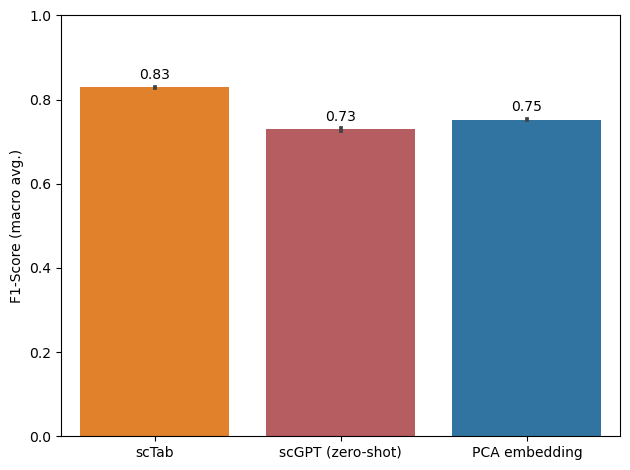

In [47]:
df = pd.DataFrame({
    'f1-score (macro avg.)': f1_scores_tabnet + f1_scores_scgpt + f1_scores_pca,
    'model': ['scTab'] * len(f1_scores_tabnet) + ['scGPT (zero-shot)'] * len(f1_scores) + ['PCA embedding'] * len(f1_scores_pca)
})

ax = sns.barplot(
    x='model',
    y='f1-score (macro avg.)',
    #hue='model',
    data=df,
    errorbar='sd',
    palette=['#ff7f0e', '#C44E52', '#1f77b4']
)
ax.set_ylabel('F1-Score (macro avg.)')
ax.set_xlabel('')
ax.set_ylim(0, 1)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_figures/scGPT_zero_shot.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/supp_figures/scGPT_zero_shot.png', dpi=300)